In [65]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../classifier")
from data import DataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import prednet_model
import numpy as np
import matplotlib.gridspec as gridspec
import utils
import os

In [46]:
batch_size = 10
input_width = 160
input_height = 128
seq_length=10

def resize(img):
    return utils.resize_img(img, target_size=(input_height, input_width))
    
training_data_dir = '../../datasets/moments_audio_frames/validation'
generator = DataGenerator(seq_length=seq_length,
                          sample_step=1,
                          batch_size=batch_size,
                          seq_overlap=5,
                          #min_seq_length=10,
                          #pad_sequences=True,
                          max_seq_per_source=5,
                          rescale= 1./255,
                          target_size=None,
                          shuffle=False,
                          fn_preprocess=resize,
                          #output_mode='error',
                          return_sources=True,
                          classes=['speaking'],
                          index_start=0,
                          max_per_class=None)
generator = generator.flow_from_directory(training_data_dir)
iterator = iter(generator)

Found 1280 samples belonging to 1 classes in ../../datasets/moments_audio_frames/validation
Found 200 sequences belonging to 1 classes
Sequence distribution:
- 200 sequences of length 10
Total samples used: 1200
Total sources used: 40
Data shape: (10, 128, 160, 3)


In [86]:
def predict_frames(model, actual_frames):
    
    layer_config = model.layers[1].get_config()
    data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
    
    if data_format == 'channels_first':
        actual_frames = np.transpose(actual_frames, (0, 1, 4, 2, 3))
    
    X_hat = model.predict(actual_frames)
    if data_format == 'channels_first':
        X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))
    return X_hat

def plot(frames, label=None, plot_save_dir='./results'):
    # Plot some predictions
    n_timesteps =  frames.shape[0]
    aspect_ratio = float(frames.shape[1]) / frames.shape[2]
    plt.figure(figsize = (4 * n_timesteps, 8 * aspect_ratio))
    gs = gridspec.GridSpec(2, n_timesteps)
    gs.update(wspace=.02, hspace=0.)
    #plot_save_dir = os.path.join(results_dir, 'prediction_plots/')
    #if not os.path.exists(plot_save_dir): os.makedirs(plot_save_dir)

    for t in range(len(frames)):
        plt.subplot(gs[t])
        plt.imshow(frames[t], interpolation='none')
        plt.tick_params(axis='both', which='both', 
                        bottom=False, top=False, 
                        left=False, right=False, 
                        labelbottom=False, labelleft=False)
        #if t==0 and label: plt.ylabel(label, fontsize=16)
        frame_dir = os.path.join(plot_save_dir, 'audio_frames')
        if not os.path.exists(frame_dir):
            os.makedirs(frame_dir)
    
    #plt.savefig(os.path.join(frame_dir, 'plot_' + label + '.svg'))
    #plt.clf()
    plt.show()

In [7]:
FLAGS = {
    'config': 'prednet_random__moments_audio__prediction',
}
config_name, config = utils.get_config(FLAGS)
config['batch_size'] = batch_size
config['n_timesteps'] = seq_length
model_prediction_random = prednet_model.create_model(train=False, **config)

FLAGS = {
    'config': 'prednet_kitti__moments_audio__prediction',
}
config_name, config = utils.get_config(FLAGS)
config['batch_size'] = batch_size
config['n_timesteps'] = seq_length
model_prediction_kitti = prednet_model.create_model(train=False, **config)

FLAGS = {
    'config': 'prednet_kitti_finetuned_moments_audio__prediction',
}
FLAGS['pretrained'] = 'full'
config_name, config = utils.get_config(FLAGS)
config['batch_size'] = batch_size
config['n_timesteps'] = seq_length
model_prediction_full = prednet_model.create_model(train=False, **config)

Loading model: ./kitti/model_data/kitti_keras/prednet_kitti_weights.hdf5
Loading model: ./results/prednet_random__moments_audio__model__full/weights.hdf5


In [61]:
X, y, sources = next(iterator)

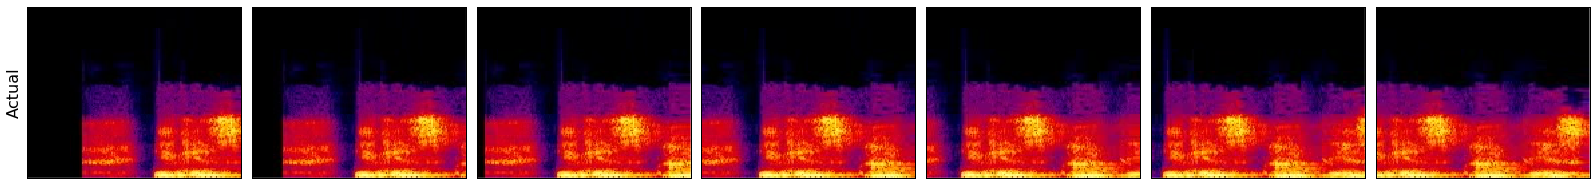

In [63]:
plot(X[6, 3:], 'Actual')

In [64]:
X_hat_random = predict_frames(model_prediction_random, X)
print(X_hat_random.shape)
X_hat_kitti = predict_frames(model_prediction_kitti, X)
print(X_hat_kitti.shape)
X_hat_full = predict_frames(model_prediction_full, X)
print(X_hat_full.shape)

(10, 10, 128, 160, 3)
(10, 10, 128, 160, 3)
(10, 10, 128, 160, 3)


### Speaking

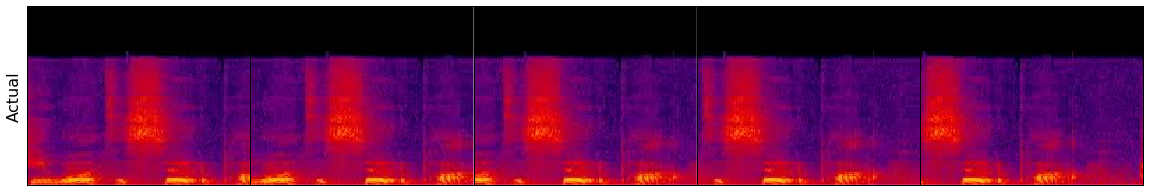

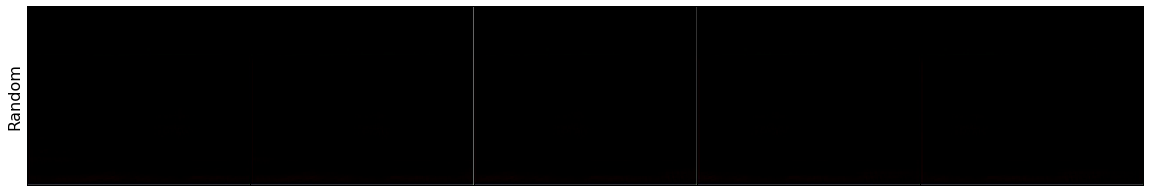

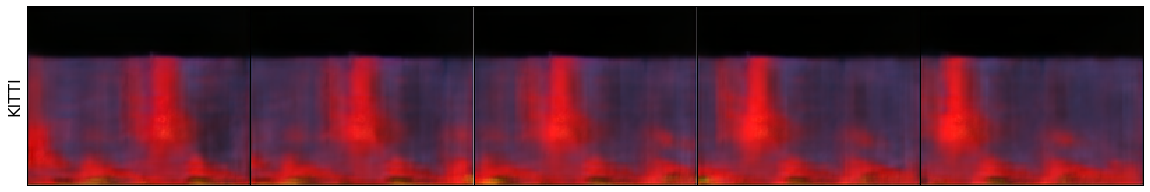

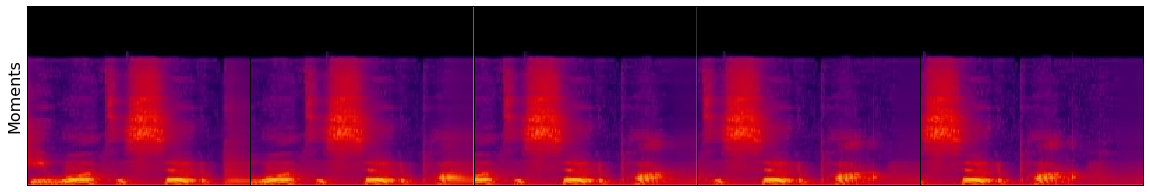

In [12]:
i = 4
plot(X[i, 5:10], 'Actual')
plot(X_hat_random[i, 5:10], 'Random')
plot(X_hat_kitti[i, 5:10], 'KITTI')
plot(X_hat_full[i, 5:10], 'Moments')

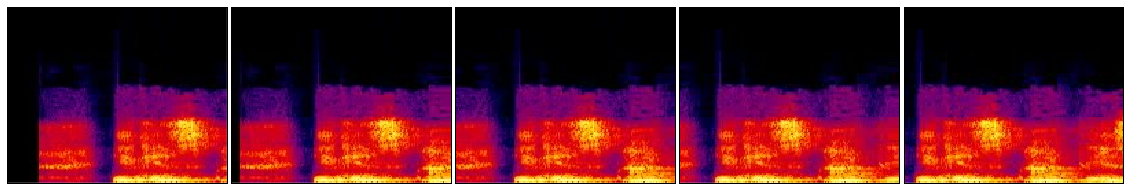

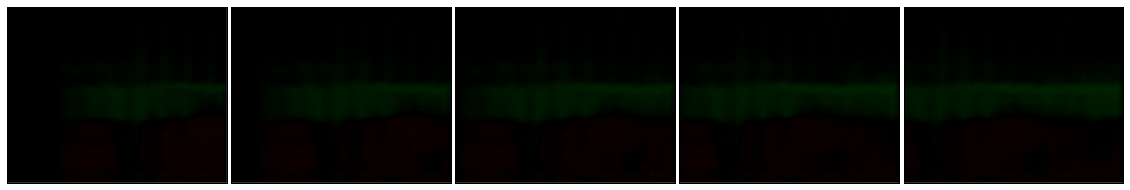

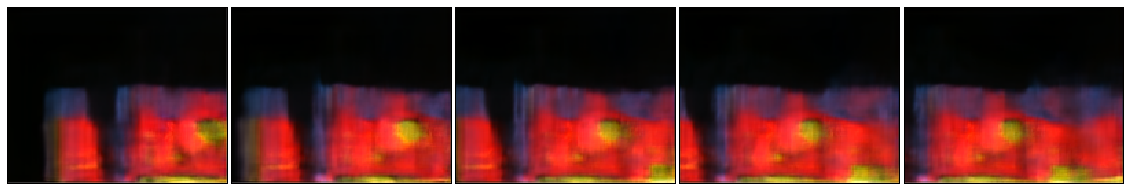

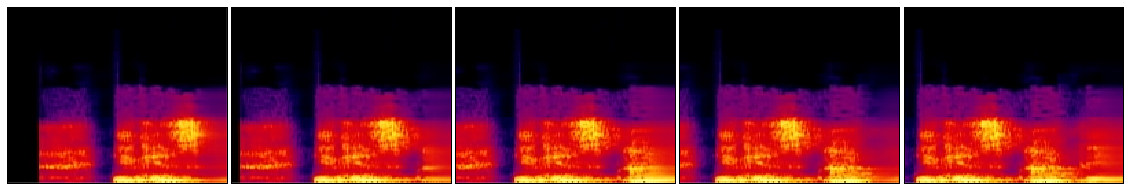

In [88]:
i = 6
t_start = 4
t_end = 9
plot(X[i, t_start:t_end])#, 'Actual')
plot(X_hat_random[i, t_start:t_end])#, 'Random')
plot(X_hat_kitti[i, t_start:t_end])#, 'KITTI')
plot(X_hat_full[i, t_start:t_end])#, 'Moments')

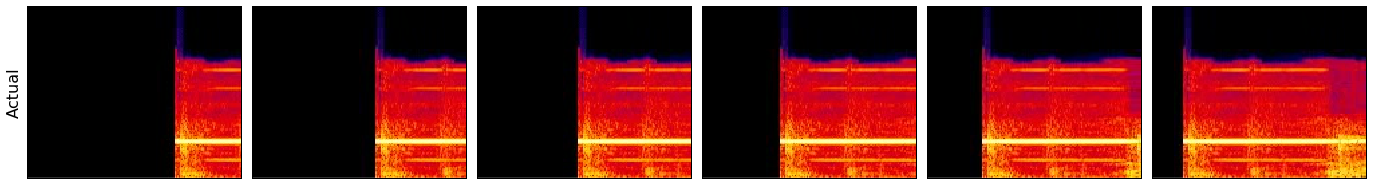

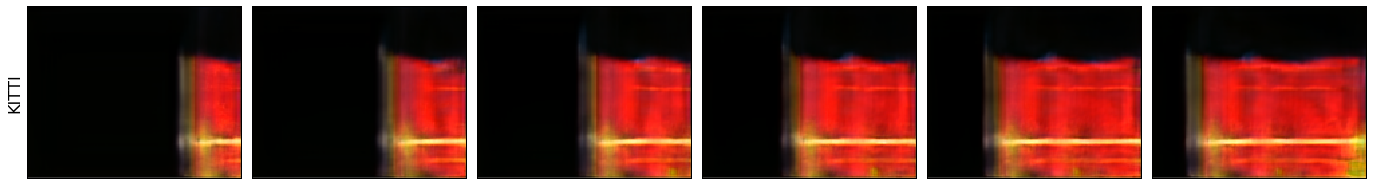

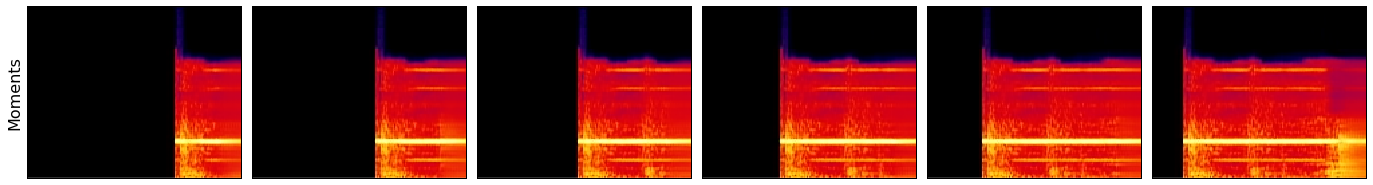

In [59]:
i = 5
t_start = 4
plot(X[i, t_start:], 'Actual')
#plot(X_hat_random[i, t_start:], 'Random')
plot(X_hat_kitti[i, t_start:], 'KITTI')
plot(X_hat_full[i, t_start:], 'Moments')